# Import and put data into dataframe

In [1]:
!pip install kagglehub

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("wajahat1064/emotion-recognition-using-eeg-and-computer-games")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\nolan\.cache\kagglehub\datasets\wajahat1064\emotion-recognition-using-eeg-and-computer-games\versions\2


In [3]:
import pandas as pd
import numpy as np
import matplotlib as plt
df = pd.read_csv('/Users/nolan/.cache/kagglehub/datasets/wajahat1064/emotion-recognition-using-eeg-and-computer-games/versions/2/S01G1AllChannels.csv')
df.head()


,AF3,AF4,F3,F4,F7,F8,FC5,FC6,O1,O2,P7,P8,T7,T8,Unnamed: 14
0,-33.0205,-15.1846,-42.1795,1.6872,42.1793,-1.68720,-5.5436,-3.6154,25.7899,-9.88190,5.5436,7.47180,11.8101,17.1128,NaN
1,-28.6291,-20.0583,-42.5410,-10.4653,35.3100,-15.68600,-19.3110,-2.4344,17.4933,3.24420,18.7081,5.09510,17.3683,3.0708,NaN
2,-21.8497,-10.9006,-32.0346,-2.3656,39.6993,-0.64483,-4.0523,-1.0830,26.8081,-3.45840,8.1861,8.40480,15.1209,9.3940,NaN
3,-25.1185,-10.9702,-32.7641,-3.4287,32.7378,4.69650,-8.6299,-1.7412,16.7637,-9.75860,1.1868,0.91086,4.3315,8.1073,NaN
4,-19.0316,-9.5886,-29.1108,-3.9459,35.3533,0.79929,-12.6914,1.0144,13.1068,-0.73692,8.1054,-1.31300,8.1694,8.3442,NaN


In [4]:
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


# Define the bandpass filter function
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)


In [5]:
# Define the montage re-referencing function
def apply_montage(df, montage_type):
    if montage_type == "Bipolar":
        # Define pairs for bipolar montage
        pairs = {
            "AF3-AF4": ("AF3", "AF4"),
            "F3-F4": ("F3", "F4"),
            "F7-F8": ("F7", "F8"),
            "FC5-FC6": ("FC5", "FC6"),
            "O1-O2": ("O1", "O2"),
            "P7-P8": ("P7", "P8"),
            "T7-T8": ("T7", "T8")
        }
        bipolar_df = pd.DataFrame()
        for pair_name, (ch1, ch2) in pairs.items():
            if ch1 in df.columns and ch2 in df.columns:
                bipolar_df[pair_name] = df[ch1] - df[ch2]
        return bipolar_df
    elif montage_type == "Refferential":
        # Use only the valid EEG channels (exclude extraneous columns like "Unnamed: 14")
        channels = [col for col in df.columns if col != "Unnamed: 14"]
        # Compute the common average reference
        avg_ref = df[channels].mean(axis=1)
        referential_df = df[channels].subtract(avg_ref, axis=0)
        return referential_df
    else:
        raise ValueError("Unknown montage type: " + montage_type)



In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Function to process data and update the dashboard
def process_and_plot(change):
    montage_type = montage_dropdown.value
    lowcut = low_freq_input.value
    highcut = high_freq_input.value


    fs = 256  # Assumed sampling frequency (Hz)

    # Apply montage re-referencing
    processed_df = apply_montage(df, montage_type)

    # Apply band-pass filter on each channel
    filtered_df = processed_df.copy()
    for col in processed_df.columns:
        filtered_df[col] = bandpass_filter(processed_df[col].values, lowcut, highcut, fs)

    # Plot each channel's voltage trace in a dashboard (grid) layout
    n_channels = len(filtered_df.columns)
    ncols = int(np.ceil(np.sqrt(n_channels)))
    nrows = int(np.ceil(n_channels / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 10))
    
    # Add a suptitle with the montage type
    fig.suptitle(f"{montage_type} Montage ({lowcut} - {highcut})", fontsize=16)
    
    axs = axs.flatten()
    for i, col in enumerate(filtered_df.columns):
        axs[i].plot(filtered_df[col])
        axs[i].set_title(col)
        axs[i].set_xlabel("Time (samples)")
        axs[i].set_ylabel("Voltage")
    # Hide any extra subplots if needed
    for j in range(i+1, len(axs)):
        axs[j].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Calculate aggregate characteristics for each channel
    stats = []
    for col in filtered_df.columns:
        trace = filtered_df[col]
        mean_val = np.mean(trace)
        variance_val = np.var(trace)
        # Fano factor: variance divided by mean (if mean is not zero)
        fano_factor = variance_val / mean_val if mean_val != 0 else np.nan
        stats.append({"Channel": col, "Mean": mean_val, "Variance": variance_val, "Fano Factor": fano_factor})
    stats_df = pd.DataFrame(stats)
    display(stats_df)

Dropdown(description='Montage Type:', options=('Bipolar', 'Refferential'), value='Bipolar')

FloatText(value=1.0, description='Low Freq:')

FloatText(value=10.0, description='High Freq:')

Button(description='Process Data', style=ButtonStyle())

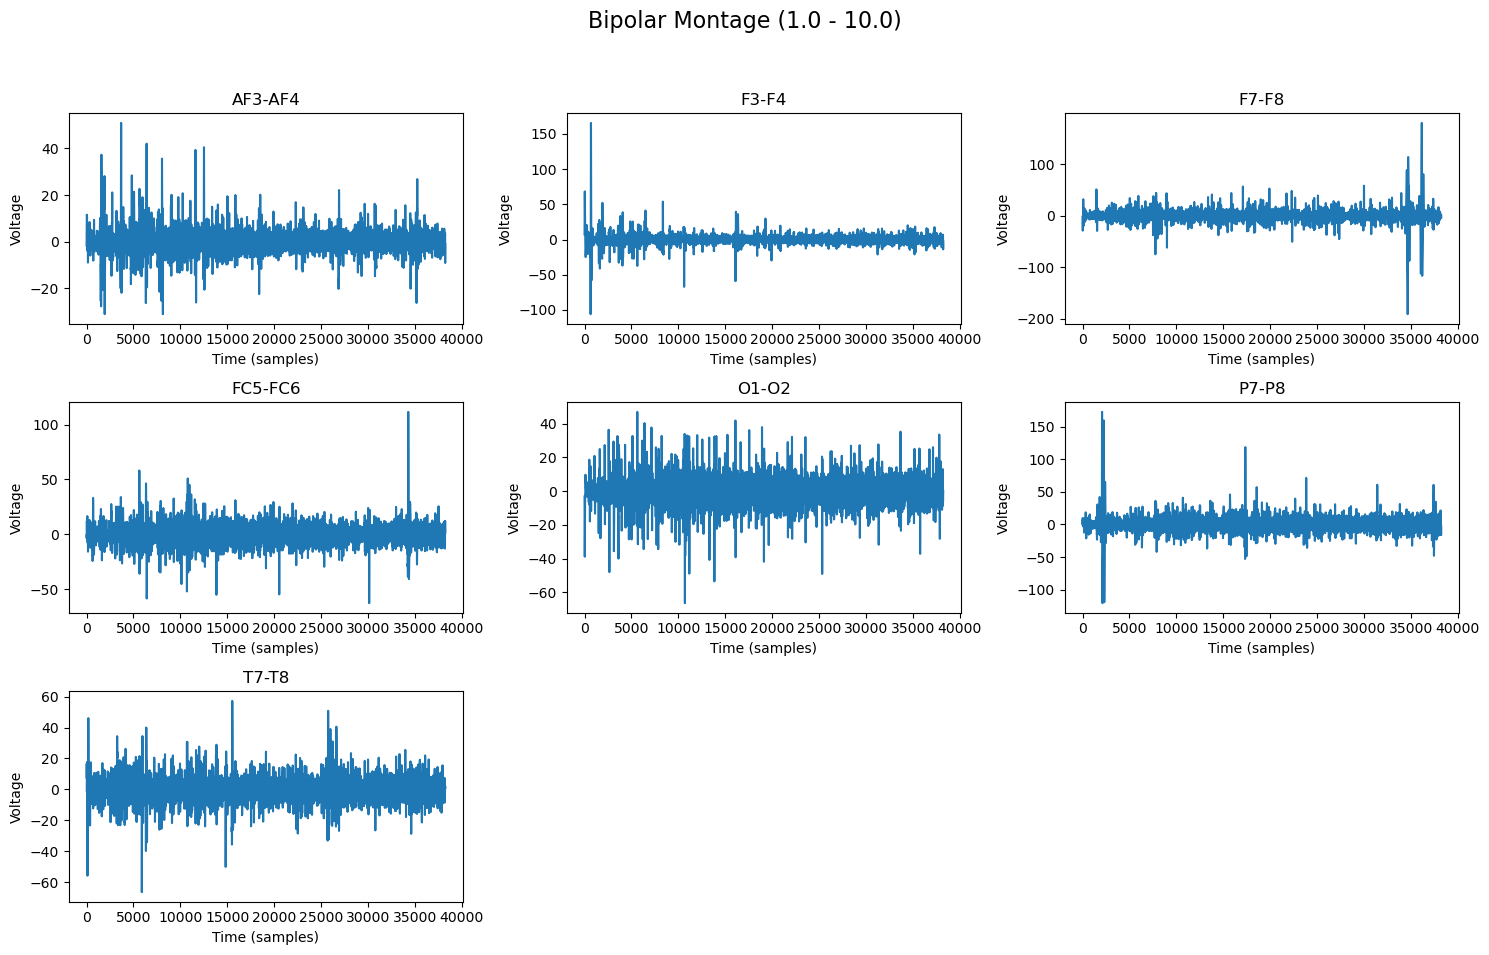

,Channel,Mean,Variance,Fano Factor
0,AF3-AF4,0.009128,33.519920,3672.195184
1,F3-F4,0.040809,74.693822,1830.318160
2,F7-F8,-0.019972,219.713677,-11000.924845
3,FC5-FC6,0.003635,95.025101,26142.947487
4,O1-O2,-0.025031,80.924429,-3233.009166
5,P7-P8,0.004911,162.683303,33125.865699
6,T7-T8,-0.001423,76.883616,-54026.995728


In [ ]:

# Create frequency input widgets
low_freq_input = widgets.FloatText(value=1.0, description='Low Freq:')
high_freq_input = widgets.FloatText(value=10.0, description='High Freq:')

# Create montage dropdown widget (ensure these options match your re-referencing function)
montage_types = ["Bipolar", "Refferential"]
montage_dropdown = widgets.Dropdown(options=montage_types, description='Montage Type:')

# Create a button widget to trigger processing
process_button = widgets.Button(description="Process Data")
process_button.on_click(process_and_plot)

# Display the widgets
display(montage_dropdown, low_freq_input, high_freq_input, process_button)

